In [16]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import OneCycleLR
import wandb
import warnings
warnings.filterwarnings('ignore')

# Setup thiết bị và seed cho reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(40)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"Device: {device}")


Device: cuda


# **Block 1: Data Preparation and Splitting**

In [17]:
# audio path
DATA_DIR = r"D:\SU25\DPL302\Asm\wav"

files = [f for f in os.listdir(DATA_DIR) if f.endswith('.wav')]
print(f"Found {len(files)} audio files")

records = []
for fname in files:
    speaker = fname[0:2]      # 2 ký tự đầu: ID người nói (01-10)
    text_code = fname[2:5]    # 3 ký tự tiếp: mã văn bản (a01-b03)
    emotion = fname[5]        # 1 ký tự: mã cảm xúc (W,L,E,A,F,T,N)
    version = fname[6] if len(fname) >= 7 else ''  # phiên bản ghi âm (a,b)
    
    records.append({
        'filename': fname,
        'speaker': speaker,
        'text': text_code,
        'emotion': emotion,
        'version': version
    })

# Tạo DataFrame từ records
df = pd.DataFrame(records)
print(f"Created dataframe with {len(df)} records")

# Mapping từ emotion codes sang emotion labels
emotion_map = {
    'W': 'anger',     
    'L': 'boredom',     
    'E': 'disgust',    
    'A': 'fear',       
    'F': 'happiness', 
    'T': 'sadness',    
    'N': 'neutral'    
}
df['emotion_label'] = df['emotion'].map(emotion_map)

# Thống kê phân bố dữ liệu
print("\nEmotion distribution:")
emotion_counts = df['emotion_label'].value_counts().sort_index()
print(emotion_counts)

print("\nSpeaker distribution:")
speaker_counts = df['speaker'].value_counts().sort_index()
print(speaker_counts)

# Phân chia dữ liệu: 70% train, 15% validation, 15% test
# Sử dụng stratify để đảm bảo tỷ lệ emotion giống nhau ở các split
train_df, temp_df = train_test_split(
    df, test_size=0.30, 
    stratify=df['emotion_label'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, 
    stratify=temp_df['emotion_label'], 
    random_state=42
)

print(f"\nData split:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Lưu các split ra file CSV để có thể tái sử dụng
train_df.to_csv("emodb_train.csv", index=False)
val_df.to_csv("emodb_val.csv", index=False)
test_df.to_csv("emodb_test.csv", index=False)

Found 535 audio files


Created dataframe with 535 records

Emotion distribution:
emotion_label
anger        127
boredom       81
disgust       46
fear          69
happiness     71
neutral       79
sadness       62
Name: count, dtype: int64

Speaker distribution:
speaker
03    49
08    58
09    43
10    38
11    55
12    35
13    61
14    69
15    56
16    71
Name: count, dtype: int64

Data split:
Train: 374 samples
Validation: 80 samples
Test: 81 samples


# **Block 2: Audio Feature Extraction**

In [18]:
def extract_audio_features(file_path, sr=16000, n_mfcc=13):
    """
    Trích xuất đặc trưng âm thanh từ file audio
    
    Args:
        file_path (str): Đường dẫn tới file audio
        sr (int): Sample rate để load audio (16kHz phù hợp cho speech)
        n_mfcc (int): Số lượng MFCC coefficients
    
    Returns:
        np.array: Vector đặc trưng 1D có 35 features
    """
    try:
        # 1. Load file audio và downsample về sample rate mong muốn
        y, _ = librosa.load(file_path, sr=sr)
        
        # 2. Normalize amplitude để tránh clipping và chuẩn hóa volume
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))
        
        # 3. Trim silence ở đầu và cuối để loại bỏ khoảng lặng
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # 4. MFCC (Mel-frequency cepstral coefficients) - 13 features
        # Đặc trưng quan trọng nhất cho speech recognition và emotion recognition
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs, axis=1)  # Lấy mean theo time axis
        
        # 5. Chroma features - 12 features  
        # Thể hiện pitch class profile, quan trọng cho tonal content
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)
        
        # 6. Spectral Contrast - 7 features
        # Đo lường sự khác biệt giữa peaks và valleys trong spectrum
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(contrast, axis=1)
        
        # 7. Zero Crossing Rate - 1 feature
        # Tỷ lệ signal băng qua zero, chỉ số về voiced/unvoiced
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        
        # 8. Spectral Rolloff - 1 feature
        # Tần số mà dưới đó chứa 85% năng lượng phổ
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        
        # 9. Spectral Centroid - 1 feature
        # "Brightness" của âm thanh, trọng tâm phổ tần
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # Kết hợp tất cả features: 13+12+7+1+1+1 = 35 features
        feature_vector = np.hstack([
            mfccs_mean,      # 13 features
            chroma_mean,     # 12 features  
            contrast_mean,   # 7 features
            zcr,            # 1 feature
            rolloff,        # 1 feature
            centroid        # 1 feature
        ])
        
        return feature_vector
        
    except Exception:
        return np.zeros(35)

def process_audio_split(split_name, csv_path):
    """
    Xử lý một split (train/val/test) và trích xuất features cho tất cả files

    Args:
        split_name (str): Tên split
        csv_path (str): Đường dẫn tới CSV file chứa danh sách files
    """
    df = pd.read_csv(csv_path)
    features = []

    for _, row in df.iterrows():
        wav_path = os.path.join(DATA_DIR, row['filename'])
        feature_vector = extract_audio_features(wav_path)
        features.append(feature_vector)

    feature_array = np.array(features)

    feature_columns = (
        [f'mfcc_{i+1}' for i in range(13)] +      # MFCC features
        [f'chroma_{i+1}' for i in range(12)] +    # Chroma features
        [f'contrast_{i+1}' for i in range(7)] +   # Spectral contrast features
        ['zcr', 'rolloff', 'centroid']            # Additional features
    )

    features_df = pd.DataFrame(feature_array, columns=feature_columns)
    features_df['emotion_label'] = df['emotion_label'].values

    output_file = f"emodb_{split_name}_features.csv"
    features_df.to_csv(output_file, index=False)

# Danh sách các split cần xử lý
splits_to_process = [
    ('train', 'emodb_train.csv'),
    ('val', 'emodb_val.csv'),
    ('test', 'emodb_test.csv')
]

for split_name, csv_file in splits_to_process:
    process_audio_split(split_name, csv_file)

print("\nFeature extraction completed!")


Feature extraction completed!


# **Block 3: Data Loading and Preprocessing**

In [19]:
# ===================================================================
# BLOCK 3: LOAD VÀ CHUẨN BỊ DỮ LIỆU CHO TRAINING
# ===================================================================

# Load các feature files đã được xử lý
train_df = pd.read_csv('emodb_train_features.csv')
val_df = pd.read_csv('emodb_val_features.csv')
test_df = pd.read_csv('emodb_test_features.csv')

print(f"Train features: {train_df.shape}")
print(f"Val features: {val_df.shape}")
print(f"Test features: {test_df.shape}")

# Tách features và labels
feature_columns = [col for col in train_df.columns if col != 'emotion_label']
print(f"Number of features: {len(feature_columns)}")

# Tạo arrays cho features và labels
X_train = train_df[feature_columns].values
y_train = train_df['emotion_label'].values
X_val = val_df[feature_columns].values
y_val = val_df['emotion_label'].values
X_test = test_df[feature_columns].values
y_test = test_df['emotion_label'].values

print(f"Feature shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Encode emotion labels thành integers
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

print(f"Label encoding:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"  {emotion}: {i}")

# Standardize features để có mean=0, std=1
# Quan trọng cho neural networks để training stable
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features standardized")

# Tạo PyTorch datasets và dataloaders
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32), 
    torch.tensor(y_train_enc, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32), 
    torch.tensor(y_val_enc, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32), 
    torch.tensor(y_test_enc, dtype=torch.long)
)

# Tạo data loaders với batch size 64
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data loaders created with batch size {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Lưu thông tin cơ bản cho models
input_dim = X_train_scaled.shape[1]
num_classes = len(label_encoder.classes_)

print(f"\nModel parameters:")
print(f"  Input dimension: {input_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {list(label_encoder.classes_)}")

Train features: (374, 36)
Val features: (80, 36)
Test features: (81, 36)
Number of features: 35
Feature shapes - Train: (374, 35), Val: (80, 35), Test: (81, 35)
Label encoding:
  anger: 0
  boredom: 1
  disgust: 2
  fear: 3
  happiness: 4
  neutral: 5
  sadness: 6
Features standardized
Data loaders created with batch size 64
  Train batches: 6
  Val batches: 2
  Test batches: 2

Model parameters:
  Input dimension: 35
  Number of classes: 7
  Classes: ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']


# **Block4: Data Analysis and Visualization**

=== Data Overview ===
Total samples: 374
Unique speakers: 10
Unique emotions: 7

Emotion distribution:
emotion_label
anger        89
boredom      57
neutral      55
happiness    50
fear         48
sadness      43
disgust      32
Name: count, dtype: int64

Speaker distribution:
speaker
16    54
13    44
14    42
8     42
15    38
3     36
11    33
9     32
10    29
12    24
Name: count, dtype: int64


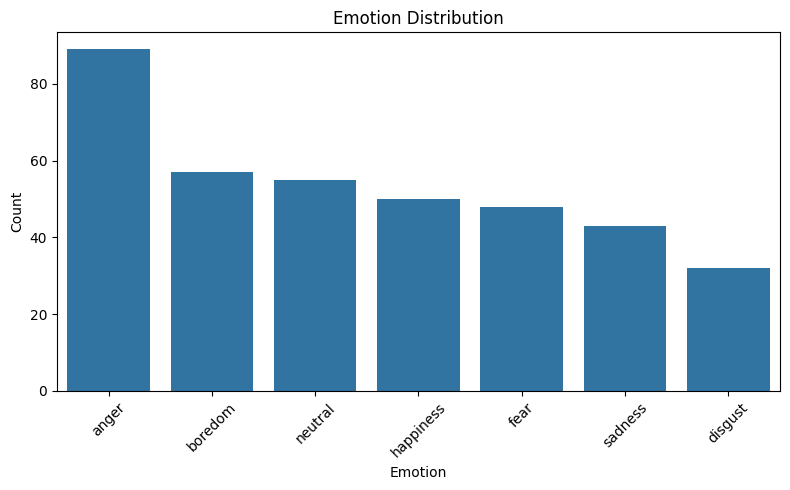

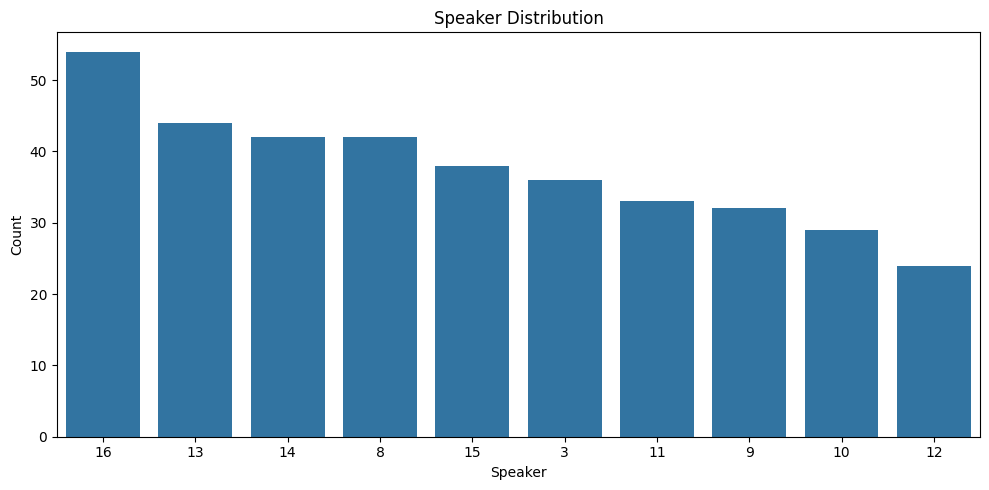


Emotion counts per speaker:
emotion_label  anger  boredom  disgust  fear  happiness  neutral  sadness
speaker                                                                  
3                 12        1        0     3          5        9        6
8                  8        7        0     5         10        6        6
9                 10        4        6     0          1        7        4
10                 8        6        1     6          4        3        1
11                 6        5        2     6          3        8        3
12                 9        3        2     2          1        3        4
13                 9        6        6     4          9        7        3
14                10        6        6    10          4        0        6
15                 8        5        3     7          5        7        3
16                 9       14        6     5          8        5        7


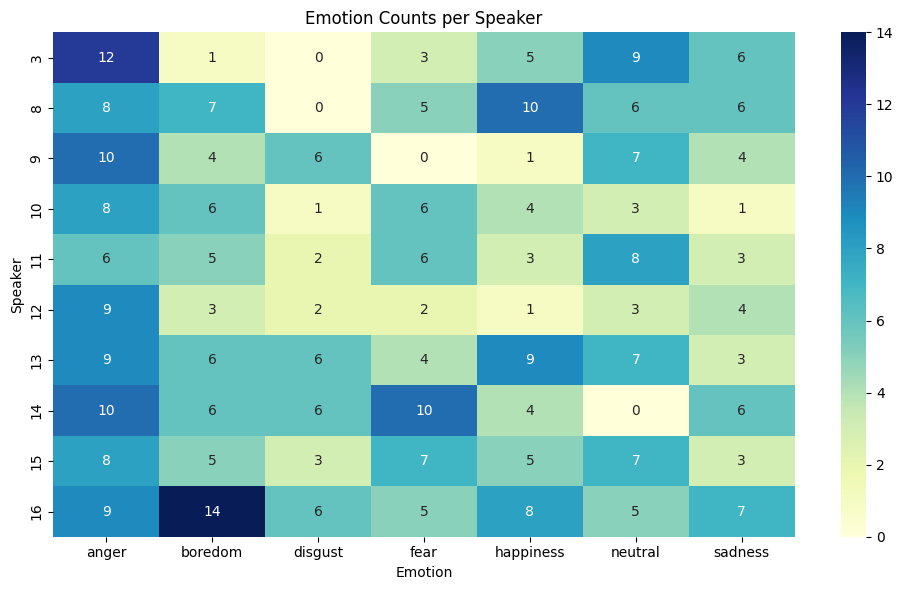

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the train split (or the full dataset as needed)
df = pd.read_csv('emodb_train.csv')

print("=== Data Overview ===")
print(f"Total samples: {len(df)}")
print(f"Unique speakers: {df['speaker'].nunique()}")
print(f"Unique emotions: {df['emotion_label'].nunique()}")
print("\nEmotion distribution:")
print(df['emotion_label'].value_counts())
print("\nSpeaker distribution:")
print(df['speaker'].value_counts())

# Plot emotion distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion_label', order=df['emotion_label'].value_counts().index)
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot speaker distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='speaker', order=df['speaker'].value_counts().index)
plt.title('Speaker Distribution')
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Crosstab: emotion vs speaker
crosstab = pd.crosstab(df['speaker'], df['emotion_label'])
print("\nEmotion counts per speaker:")
print(crosstab)

# Heatmap for emotion per speaker
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Emotion Counts per Speaker')
plt.xlabel('Emotion')
plt.ylabel('Speaker')
plt.tight_layout()
plt.show()


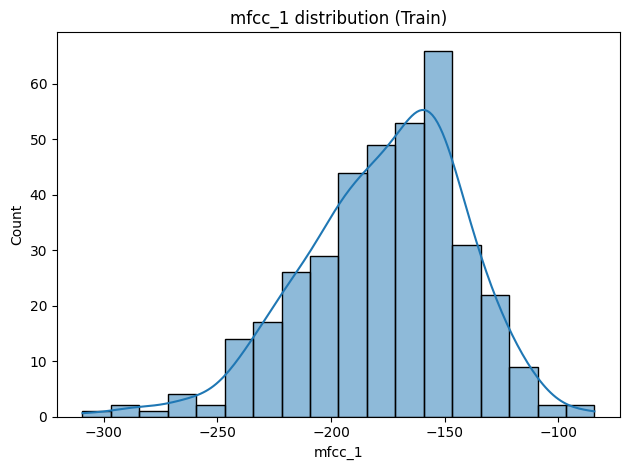

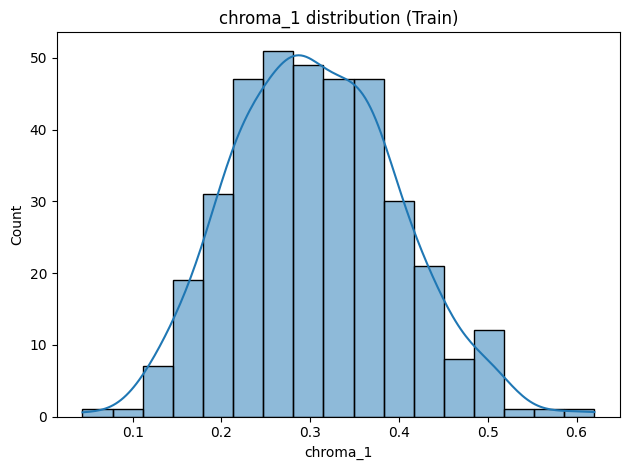

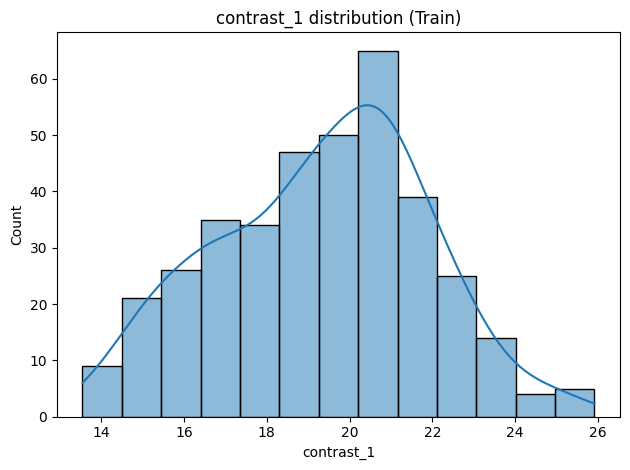

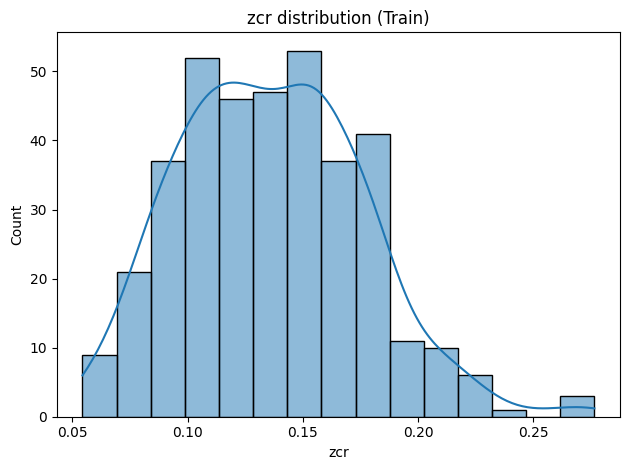

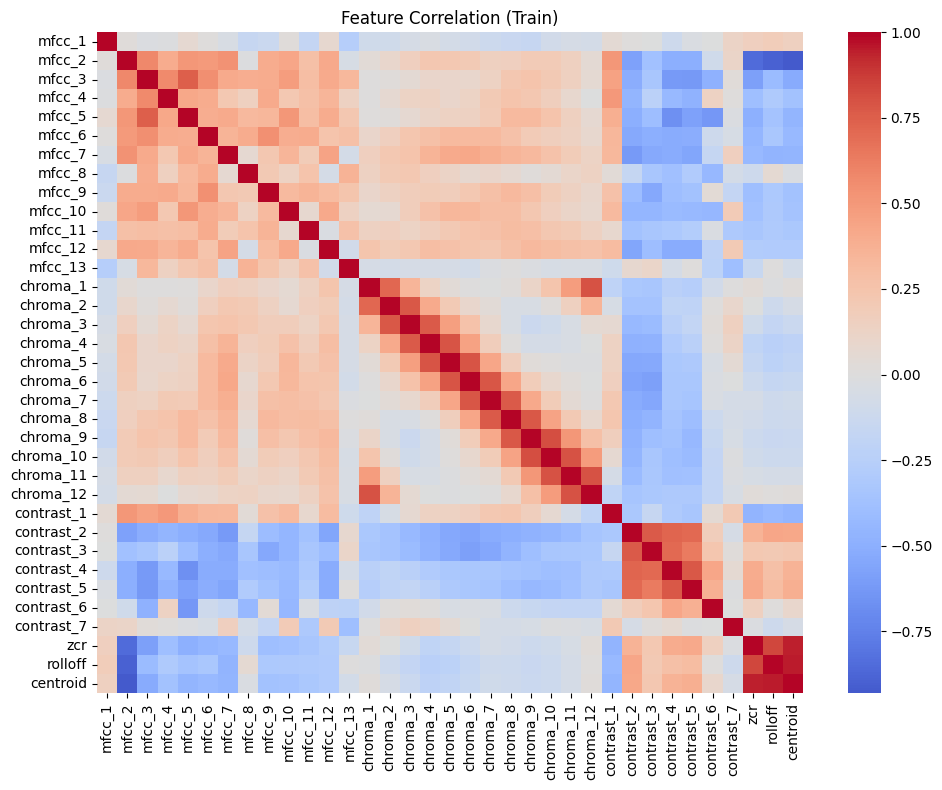

In [21]:
# Visualize distribution of selected features
for feat in ['mfcc_1', 'chroma_1', 'contrast_1', 'zcr']:
    plt.figure()
    sns.histplot(train_df[feat], kde=True)
    plt.title(f'{feat} distribution (Train)')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Correlation heatmap for all features (excluding label)
plt.figure(figsize=(10, 8))
corr = train_df.drop(columns=['emotion_label']).corr()
sns.heatmap(corr, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Feature Correlation (Train)')
plt.tight_layout()
plt.show()

# **Block 4: Model Definitions**

In [22]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def print_model_info(model, model_name):
    total_params, trainable_params = count_parameters(model)
    print(f"\n{model_name} Model Info:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

## **4.1-ShallowNeuralNetwork**: Simple feedforward neural network

In [23]:
class ShallowNeuralNetwork(nn.Module):
    """
    MODEL 1: ShallowNeuralNetwork - Simple Feedforward Network

    Architecture:
    - Input (35) -> Hidden1 (128) -> Hidden2 (64) -> Output (7)
    - ReLU activation functions after each hidden layer
    - Dropout layers (p=0.3) for regularization after each hidden layer
    """
    def __init__(self, input_dim, num_classes):
        super(ShallowNeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            # Layer 1: Input -> Hidden1
            nn.Linear(input_dim, 128),   # 35 -> 128
            nn.ReLU(),                   # Activation
            nn.Dropout(0.3),             # Regularization

            # Layer 2: Hidden1 -> Hidden2  
            nn.Linear(128, 64),          # 128 -> 64
            nn.ReLU(),                   # Activation
            nn.Dropout(0.3),             # Regularization

            # Output layer: Hidden2 -> Output
            nn.Linear(64, num_classes)   # 64 -> 7
        )

    def forward(self, x):
        # Forward pass through all layers as defined above
        return self.network(x)

## **4.2-DeepNeuralNetwork**: Feedforward network with batch normalization

In [24]:
class DeepNeuralNetwork(nn.Module):
    """
    MODEL: DeepNeuralNetwork - Deeper Feedforward Network

    Architecture:
    - Input (35) -> Hidden1 (512) -> Hidden2 (256) -> Hidden3 (128) -> Hidden4 (64) -> Output (7)
    - Each hidden layer uses Batch Normalization for training stability.
    - LeakyReLU activation after each hidden layer.
    - Dropout (p=0.2) after each hidden layer to reduce overfitting.
    """
    def __init__(self, input_dim, num_classes):
        super(DeepNeuralNetwork, self).__init__()
        # Layer 1: Input -> 512
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        # Layer 2: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        # Layer 3: 256 -> 128
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        # Layer 4: 128 -> 64
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        # Output layer: 64 -> num_classes
        self.fc5 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        # Layer 1: Linear -> BatchNorm -> LeakyReLU -> Dropout
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        # Layer 2
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        # Layer 3
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        # Layer 4
        x = self.activation(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        # Output layer (no activation)
        return self.fc5(x)

## **4.3-ResidualModel**: Feedforward network with skip connections

In [25]:
import torch.nn as nn

class ResidualModel(nn.Module):
    """
    MODEL 3: RESIDUAL - With Skip Connections

    Architecture:
    - Input (feature_dim) -> Linear(256) -> BatchNorm -> LeakyReLU -> Dropout
    - Residual Block 1: 256 -> 256 (skip connection)
      - Linear(256) -> BatchNorm -> LeakyReLU -> Dropout
      - Linear(256) -> BatchNorm
      - Add skip connection, then LeakyReLU and Dropout
    - Residual Block 2: 256 -> 128 (skip connection with downsampling)
      - Linear(256,128) -> BatchNorm -> LeakyReLU -> Dropout
      - Linear(128,128) -> BatchNorm
      - Downsample skip connection to 128, add, then LeakyReLU and Dropout
    - Output: Linear(128, num_classes)
    """
    def __init__(self, input_dim, num_classes):
        super(ResidualModel, self).__init__()
        # Input projection: Input -> 256
        self.input_proj = nn.Linear(input_dim, 256)
        self.input_bn = nn.BatchNorm1d(256)

        # Residual Block 1: 256 -> 256
        self.res1_fc1 = nn.Linear(256, 256)
        self.res1_bn1 = nn.BatchNorm1d(256)
        self.res1_fc2 = nn.Linear(256, 256)
        self.res1_bn2 = nn.BatchNorm1d(256)

        # Residual Block 2: 256 -> 128
        self.res2_fc1 = nn.Linear(256, 128)
        self.res2_bn1 = nn.BatchNorm1d(128)
        self.res2_fc2 = nn.Linear(128, 128)
        self.res2_bn2 = nn.BatchNorm1d(128)

        # Downsample for skip connection in Block 2
        self.downsample = nn.Linear(256, 128)

        # Output layer: 128 -> num_classes
        self.output = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        # Input projection
        x = self.activation(self.input_bn(self.input_proj(x)))
        x = self.dropout(x)

        # Residual Block 1: F(x) + x
        identity1 = x
        out = self.activation(self.res1_bn1(self.res1_fc1(x)))
        out = self.dropout(out)
        out = self.res1_bn2(self.res1_fc2(out))
        out += identity1  # Skip connection
        out = self.activation(out)
        out = self.dropout(out)

        # Residual Block 2: F(x) + downsample(x)
        identity2 = self.downsample(out)
        out = self.activation(self.res2_bn1(self.res2_fc1(out)))
        out = self.dropout(out)
        out = self.res2_bn2(self.res2_fc2(out))
        out += identity2  # Skip connection
        out = self.activation(out)
        out = self.dropout(out)

        # Output layer
        return self.output(out)

## **4.4-LSTMModel**: Bidirectional LSTM network for sequence modeling.

In [26]:
import torch.nn as nn

class LSTMModel(nn.Module):
    """
    MODEL 4: LSTM

    LSTM-based architecture for sequence modeling:
    - Reshapes input features into sequences for temporal modeling.
    - Uses multi-layer, bidirectional LSTM to capture both past and future dependencies in the sequence.
    - Final classification layers map LSTM output to class predictions.
    """
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_layers=2):
        super(LSTMModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Decide how to split input features into sequences
        # Example: 35 features -> 5 sequences of 7 features each
        self.seq_len = 5
        self.feature_per_seq = input_dim // self.seq_len

        # If not evenly divisible, pad with zeros
        if input_dim % self.seq_len != 0:
            self.feature_per_seq += 1
            self.padded_input_dim = self.seq_len * self.feature_per_seq
        else:
            self.padded_input_dim = input_dim

        # Optional input projection if padding is needed
        if self.padded_input_dim != input_dim:
            self.input_proj = nn.Linear(input_dim, self.padded_input_dim)
        else:
            self.input_proj = None

        # LSTM layer(s): bidirectional, with dropout if num_layers > 1
        self.lstm = nn.LSTM(
            input_size=self.feature_per_seq,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0,
            bidirectional=True
        )

        # Classification head
        lstm_output_dim = hidden_dim * 2  # for bidirectional
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        batch_size = x.size(0)

        # Project input if padding was needed
        if self.input_proj is not None:
            x = self.input_proj(x)

        # Reshape to (batch, seq_len, feature_per_seq)
        x = x.view(batch_size, self.seq_len, self.feature_per_seq)

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use output from the last timestep
        final_output = lstm_out[:, -1, :]

        # Classification layers
        output = self.classifier(final_output)
        return output

In [27]:
models = {
    "Shallow_Neural_Network": ShallowNeuralNetwork(input_dim, num_classes),
    "Deep_Neural_Network": DeepNeuralNetwork(input_dim, num_classes),
    "Residual_Model": ResidualModel(input_dim, num_classes),
    "LSTM_Model": LSTMModel(input_dim, num_classes, hidden_dim=128, num_layers=2)
}

# print model info
for model_name, model in models.items():
    print_model_info(model, model_name)

print("\nAll models initialized successfully!")


Shallow_Neural_Network Model Info:
  Total parameters: 13,319
  Trainable parameters: 13,319
  Model size: 0.05 MB (float32)

Deep_Neural_Network Model Info:
  Total parameters: 193,287
  Trainable parameters: 193,287
  Model size: 0.74 MB (float32)

Residual_Model Model Info:
  Total parameters: 226,055
  Trainable parameters: 226,055
  Model size: 0.86 MB (float32)

LSTM_Model Model Info:
  Total parameters: 552,455
  Trainable parameters: 552,455
  Model size: 2.11 MB (float32)

All models initialized successfully!


# **Block 6: Training and Evaluation Functions**

In [28]:
def train_model(model, model_name, num_epochs=100, lr=1e-3, patience=15):
    wandb.init(
        project="emotion-recognition",
        name=model_name,
        config={
            "model": model_name,
            "epochs": num_epochs,
            "learning_rate": lr,
            "batch_size": batch_size,
            "input_dim": input_dim,
            "num_classes": num_classes
        }
    )
    
    # Move model to device
    model = model.to(device)
    
    # Setup optimizer và scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = OneCycleLR(
        optimizer, 
        max_lr=lr * 10,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
    
    # Setup loss function với class weights để handle imbalanced data
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_train_enc), 
        y=y_train_enc
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    print(f"Class weights: {class_weights}")
    
    # Training variables
    best_val_acc = 0.0
    patience_counter = 0
    model_path = f"best_{model_name.lower()}_model.pth"
    
    print(f"\nTraining {model_name} Model:")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {lr}")
    print(f"  Patience: {patience}")
    print(f"  Model will be saved as: {model_path}")
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping để tránh exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            # Accumulate metrics
            train_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item() * batch_x.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calculate epoch metrics
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Log to wandb - chỉ log metrics cần thiết
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        # Print progress
        if epoch % 10 == 0 or epoch <= 5:
            print(f"Epoch {epoch:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
        # Early stopping and model saving
        if val_acc > best_val_acc + 1e-4:  # Improvement threshold
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
            
            if epoch % 10 != 0 and epoch > 5:
                print(f"Epoch {epoch:3d}/{num_epochs} | "
                      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                      f"*** NEW BEST ***")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}!")
            break
    
    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    
    # Finish wandb run
    wandb.finish()
    
    return model_path, best_val_acc

def test_model(model, model_name, model_path):
    # Initialize wandb run cho testing
    wandb.init(
        project="emotion-recognition",
        name=f"{model_name}_test",
        config={
            "model": model_name, 
            "phase": "test",
            "num_classes": num_classes
        }
    )
    
    # Load best model weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    print(f"\nTesting {model_name} Model:")
    
    # Test phase
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    # Calculate test accuracy
    test_acc = accuracy_score(all_labels, all_preds)
    
    # Convert predictions back to emotion labels
    pred_emotions = label_encoder.inverse_transform(all_preds)
    true_emotions = label_encoder.inverse_transform(all_labels)
    
    # Print results
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(true_emotions, pred_emotions, digits=4))
    
    # Log test accuracy to wandb
    wandb.log({"test_accuracy": test_acc})
    
    # Finish wandb run
    wandb.finish()
    
    return test_acc

def compare_models(results):
    print("\n" + "="*70)
    print("FINAL MODEL COMPARISON")
    print("="*70)
    
    # Tạo comparison table
    comparison_data = []
    for model_name, result in results.items():
        model = models[model_name]
        total_params, trainable_params = count_parameters(model)
        
        comparison_data.append({
            'Model': model_name,
            'Parameters': f"{total_params:,}",
            'Best Val Acc': f"{result['best_val_acc']:.4f}",
            'Test Acc': f"{result['test_acc']:.4f}",
            'Model Size (MB)': f"{total_params * 4 / 1024 / 1024:.2f}"
        })
    
    # Sort by test accuracy
    comparison_data.sort(key=lambda x: float(x['Test Acc']), reverse=True)
    
    # Print comparison table
    print(f"{'Model':<12} {'Parameters':<12} {'Best Val Acc':<12} {'Test Acc':<10} {'Size (MB)':<10}")
    print("-" * 70)
    for data in comparison_data:
        print(f"{data['Model']:<12} {data['Parameters']:<12} {data['Best Val Acc']:<12} {data['Test Acc']:<10} {data['Model Size (MB)']:<10}")
    
    # Find best model
    best_model = comparison_data[0]
    print(f"\nBest Model: {best_model['Model']} with Test Accuracy: {best_model['Test Acc']}")
    
    return best_model['Model']

# **Block 7: Model Training and Testing**

In [29]:
print("\n" + "="*70)
print("STARTING TRAINING PIPELINE")
print("="*70)

results = {}

# Training parameters cho từng model
training_configs = {
    "Shallow_Neural_Network": {"num_epochs": 100, "lr": 1e-3, "patience": 15},
    "Deep_Neural_Network": {"num_epochs": 100, "lr": 1e-3, "patience": 15},
    "Residual_Model": {"num_epochs": 120, "lr": 8e-4, "patience": 20},  # Deeper model cần lr thấp hơn
    "LSTM_Model": {"num_epochs": 150, "lr": 5e-4, "patience": 25}        # LSTM thường cần nhiều epochs hơn
}

# Train và test từng model
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"PROCESSING {model_name.upper()} MODEL")
    print(f"{'='*50}")
    
    # Get training config cho model này
    config = training_configs[model_name]
    
    # Print model info trước khi train
    print_model_info(model, model_name)
    
    # Train model
    model_path, best_val_acc = train_model(
        model=model,
        model_name=model_name,
        num_epochs=config["num_epochs"],
        lr=config["lr"],
        patience=config["patience"]
    )
    
    # Test model
    test_acc = test_model(model, model_name, model_path)
    
    # Store results
    results[model_name] = {
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "model_path": model_path,
        "config": config
    }
    
    print(f"{model_name} completed - Val Acc: {best_val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Compare all models
best_model_name = compare_models(results)

print(f"\n{'='*70}")
print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print(f"Best performing model: {best_model_name}")
print(f"{'='*70}")


STARTING TRAINING PIPELINE

PROCESSING SHALLOW_NEURAL_NETWORK MODEL

Shallow_Neural_Network Model Info:
  Total parameters: 13,319
  Trainable parameters: 13,319
  Model size: 0.05 MB (float32)


Class weights: [0.60032103 0.93734336 1.66964286 1.11309524 1.06857143 0.97142857
 1.24252492]

Training Shallow_Neural_Network Model:
  Epochs: 100
  Learning rate: 0.001
  Patience: 15
  Model will be saved as: best_shallow_neural_network_model.pth
Epoch   1/100 | Train Loss: 1.9420 | Train Acc: 0.2005 | Val Loss: 1.9270 | Val Acc: 0.2625
Epoch   2/100 | Train Loss: 1.9042 | Train Acc: 0.2620 | Val Loss: 1.8892 | Val Acc: 0.4125
Epoch   3/100 | Train Loss: 1.8663 | Train Acc: 0.3636 | Val Loss: 1.8441 | Val Acc: 0.4375
Epoch   4/100 | Train Loss: 1.8079 | Train Acc: 0.4599 | Val Loss: 1.7829 | Val Acc: 0.5000
Epoch   5/100 | Train Loss: 1.7502 | Train Acc: 0.4840 | Val Loss: 1.6994 | Val Acc: 0.4875
Epoch   9/100 | Train Loss: 1.2408 | Train Acc: 0.6257 | Val Loss: 1.1825 | Val Acc: 0.5500 | *** NEW BEST ***
Epoch  10/100 | Train Loss: 1.0792 | Train Acc: 0.6604 | Val Loss: 1.0389 | Val Acc: 0.6375
Epoch  11/100 | Train Loss: 0.9410 | Train Acc: 0.6631 | Val Loss: 0.8906 | Val Acc: 0

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▂▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇▇███▇▇████████
train_loss,███▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▄▄▃▄▄▅▆▆▆▆▇▆▇▇█▇▇███▇████████████▇███
val_loss,███▇▇▆▆▅▄▄▃▂▂▂▂▂▁▁▂▂▁▁▂▂▂▂▂▂▂▂▃▂▁▂▂▂▃▃▃▂
epoch,40
train_acc,0.95722
train_loss,0.12645
val_acc,0.8375
val_loss,0.78618



Testing Shallow_Neural_Network Model:
Test Accuracy: 0.7160

Detailed Classification Report:
              precision    recall  f1-score   support

       anger     0.7500    0.7895    0.7692        19
     boredom     1.0000    0.5000    0.6667        12
     disgust     1.0000    0.5714    0.7273         7
        fear     0.6154    0.7273    0.6667        11
   happiness     0.5714    0.3636    0.4444        11
     neutral     0.5455    1.0000    0.7059        12
     sadness     1.0000    1.0000    1.0000         9

    accuracy                         0.7160        81
   macro avg     0.7832    0.7074    0.7115        81
weighted avg     0.7636    0.7160    0.7086        81



test_accuracy,▁
test_accuracy,0.71605


Shallow_Neural_Network completed - Val Acc: 0.8375, Test Acc: 0.7160

PROCESSING DEEP_NEURAL_NETWORK MODEL

Deep_Neural_Network Model Info:
  Total parameters: 193,287
  Trainable parameters: 193,287
  Model size: 0.74 MB (float32)


Class weights: [0.60032103 0.93734336 1.66964286 1.11309524 1.06857143 0.97142857
 1.24252492]

Training Deep_Neural_Network Model:
  Epochs: 100
  Learning rate: 0.001
  Patience: 15
  Model will be saved as: best_deep_neural_network_model.pth
Epoch   1/100 | Train Loss: 1.8566 | Train Acc: 0.2433 | Val Loss: 1.8722 | Val Acc: 0.4625
Epoch   2/100 | Train Loss: 1.5099 | Train Acc: 0.5000 | Val Loss: 1.7013 | Val Acc: 0.5000
Epoch   3/100 | Train Loss: 1.3172 | Train Acc: 0.6551 | Val Loss: 1.4444 | Val Acc: 0.5875
Epoch   4/100 | Train Loss: 1.1675 | Train Acc: 0.6952 | Val Loss: 1.1964 | Val Acc: 0.6250
Epoch   5/100 | Train Loss: 1.0585 | Train Acc: 0.7299 | Val Loss: 1.0107 | Val Acc: 0.7000
Epoch   6/100 | Train Loss: 0.8986 | Train Acc: 0.7941 | Val Loss: 0.8988 | Val Acc: 0.7375 | *** NEW BEST ***
Epoch   7/100 | Train Loss: 0.7539 | Train Acc: 0.8449 | Val Loss: 0.8144 | Val Acc: 0.7500 | *** NEW BEST ***
Epoch   8/100 | Train Loss: 0.6163 | Train Acc: 0.8583 | Val Loss: 0.6717

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▃▅▅▆▆▇▇▇██████████▇▇▇▇▇██
train_loss,█▇▆▅▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▁
val_acc,▁▂▃▄▅▆▆▇▇██▇▇▇▆▇▆▆▆▅▆▆▆▆▆▇
val_loss,█▇▆▅▄▃▃▂▁▁▁▁▁▂▂▂▃▃▃▆▄▄▅▂▃▃
epoch,26
train_acc,0.93048
train_loss,0.16999
val_acc,0.7875
val_loss,0.86078



Testing Deep_Neural_Network Model:
Test Accuracy: 0.7531

Detailed Classification Report:
              precision    recall  f1-score   support

       anger     0.8947    0.8947    0.8947        19
     boredom     0.6923    0.7500    0.7200        12
     disgust     1.0000    0.7143    0.8333         7
        fear     0.6000    0.8182    0.6923        11
   happiness     0.7143    0.4545    0.5556        11
     neutral     0.7000    0.5833    0.6364        12
     sadness     0.7500    1.0000    0.8571         9

    accuracy                         0.7531        81
   macro avg     0.7645    0.7450    0.7413        81
weighted avg     0.7644    0.7531    0.7475        81



test_accuracy,▁
test_accuracy,0.75309


Deep_Neural_Network completed - Val Acc: 0.8625, Test Acc: 0.7531

PROCESSING RESIDUAL_MODEL MODEL

Residual_Model Model Info:
  Total parameters: 226,055
  Trainable parameters: 226,055
  Model size: 0.86 MB (float32)


Class weights: [0.60032103 0.93734336 1.66964286 1.11309524 1.06857143 0.97142857
 1.24252492]

Training Residual_Model Model:
  Epochs: 120
  Learning rate: 0.0008
  Patience: 20
  Model will be saved as: best_residual_model_model.pth
Epoch   1/120 | Train Loss: 1.9309 | Train Acc: 0.1925 | Val Loss: 1.8694 | Val Acc: 0.3375
Epoch   2/120 | Train Loss: 1.6370 | Train Acc: 0.3797 | Val Loss: 1.7009 | Val Acc: 0.4750
Epoch   3/120 | Train Loss: 1.3674 | Train Acc: 0.5401 | Val Loss: 1.4625 | Val Acc: 0.5875
Epoch   4/120 | Train Loss: 1.1759 | Train Acc: 0.6203 | Val Loss: 1.1954 | Val Acc: 0.6000
Epoch   5/120 | Train Loss: 1.0040 | Train Acc: 0.6765 | Val Loss: 0.9633 | Val Acc: 0.6625
Epoch   6/120 | Train Loss: 0.7912 | Train Acc: 0.7487 | Val Loss: 0.7753 | Val Acc: 0.6875 | *** NEW BEST ***
Epoch   8/120 | Train Loss: 0.6141 | Train Acc: 0.7807 | Val Loss: 0.5535 | Val Acc: 0.7625 | *** NEW BEST ***
Epoch   9/120 | Train Loss: 0.4497 | Train Acc: 0.8476 | Val Loss: 0.4191 | Val Ac

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_acc,▁▃▄▅▆▆▆▇▇▇██████▇▇▇███████████████
train_loss,█▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_acc,▁▃▄▄▅▆▆▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▆▇
val_loss,█▇▆▅▄▃▂▂▁▁▁▂▂▁▃▂▁▃▂▃▃▃▄▃▄▄▄▅▄▅▄▃▃▄
epoch,34
train_acc,0.91711
train_loss,0.30037
val_acc,0.7875
val_loss,1.09397



Testing Residual_Model Model:
Test Accuracy: 0.7901

Detailed Classification Report:
              precision    recall  f1-score   support

       anger     0.8182    0.9474    0.8780        19
     boredom     1.0000    0.5833    0.7368        12
     disgust     0.8571    0.8571    0.8571         7
        fear     0.6667    0.9091    0.7692        11
   happiness     0.8333    0.4545    0.5882        11
     neutral     0.6923    0.7500    0.7200        12
     sadness     0.8182    1.0000    0.9000         9

    accuracy                         0.7901        81
   macro avg     0.8123    0.7859    0.7785        81
weighted avg     0.8113    0.7901    0.7802        81



test_accuracy,▁
test_accuracy,0.79012


Residual_Model completed - Val Acc: 0.8750, Test Acc: 0.7901

PROCESSING LSTM_MODEL MODEL

LSTM_Model Model Info:
  Total parameters: 552,455
  Trainable parameters: 552,455
  Model size: 2.11 MB (float32)


Class weights: [0.60032103 0.93734336 1.66964286 1.11309524 1.06857143 0.97142857
 1.24252492]

Training LSTM_Model Model:
  Epochs: 150
  Learning rate: 0.0005
  Patience: 25
  Model will be saved as: best_lstm_model_model.pth
Epoch   1/150 | Train Loss: 1.9480 | Train Acc: 0.1203 | Val Loss: 1.9469 | Val Acc: 0.1500
Epoch   2/150 | Train Loss: 1.9459 | Train Acc: 0.1390 | Val Loss: 1.9450 | Val Acc: 0.1500
Epoch   3/150 | Train Loss: 1.9436 | Train Acc: 0.1417 | Val Loss: 1.9426 | Val Acc: 0.1500
Epoch   4/150 | Train Loss: 1.9400 | Train Acc: 0.1444 | Val Loss: 1.9392 | Val Acc: 0.1500
Epoch   5/150 | Train Loss: 1.9360 | Train Acc: 0.1524 | Val Loss: 1.9334 | Val Acc: 0.1250
Epoch   7/150 | Train Loss: 1.9149 | Train Acc: 0.1684 | Val Loss: 1.9050 | Val Acc: 0.2375 | *** NEW BEST ***
Epoch   8/150 | Train Loss: 1.8834 | Train Acc: 0.2861 | Val Loss: 1.8589 | Val Acc: 0.3125 | *** NEW BEST ***
Epoch  10/150 | Train Loss: 1.6825 | Train Acc: 0.3556 | Val Loss: 1.5934 | Val Acc: 0.362

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_acc,▁▁▁▁▂▃▃▄▅▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
train_loss,███████▇▇▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂▃▄▄▅▆▅▅▆▆▇▇▇▇▇▇███▇█▇██▇▇▇██▇█▇█▇▇
val_loss,█████▇▅▅▄▃▂▂▂▂▂▁▁▂▂▂▂▁▂▃▂▂▂▂▂▃▃▃▄▄▆▃▅▅▅▄
epoch,55
train_acc,0.98128
train_loss,0.07187
val_acc,0.7
val_loss,1.23005



Testing LSTM_Model Model:
Test Accuracy: 0.7160

Detailed Classification Report:
              precision    recall  f1-score   support

       anger     0.7273    0.8421    0.7805        19
     boredom     0.9000    0.7500    0.8182        12
     disgust     0.6667    0.5714    0.6154         7
        fear     0.6923    0.8182    0.7500        11
   happiness     0.3000    0.2727    0.2857        11
     neutral     0.8889    0.6667    0.7619        12
     sadness     0.8182    1.0000    0.9000         9

    accuracy                         0.7160        81
   macro avg     0.7133    0.7030    0.7017        81
weighted avg     0.7189    0.7160    0.7110        81



test_accuracy,▁
test_accuracy,0.71605


LSTM_Model completed - Val Acc: 0.7500, Test Acc: 0.7160

FINAL MODEL COMPARISON
Model        Parameters   Best Val Acc Test Acc   Size (MB) 
----------------------------------------------------------------------
Residual_Model 226,055      0.8750       0.7901     0.86      
Deep_Neural_Network 193,287      0.8625       0.7531     0.74      
Shallow_Neural_Network 13,319       0.8375       0.7160     0.05      
LSTM_Model   552,455      0.7500       0.7160     2.11      

Best Model: Residual_Model with Test Accuracy: 0.7901

TRAINING PIPELINE COMPLETED SUCCESSFULLY!
Best performing model: Residual_Model


# **Block 8: Results Saving and Summary**

In [30]:
import json
from datetime import datetime

# detailed summary
summary = {
    "experiment_info": {
        "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": "EmoDB (Berlin Database of Emotional Speech)",
        "total_samples": len(df),
        "train_samples": len(train_df),
        "val_samples": len(val_df),
        "test_samples": len(test_df),
        "num_classes": num_classes,
        "feature_dim": input_dim,
        "emotions": list(label_encoder.classes_),
        "device": str(device)
    },
    "feature_extraction": {
        "sample_rate": 16000,
        "features": {
            "mfcc": 13,
            "chroma": 12,
            "spectral_contrast": 7,
            "zcr": 1,
            "rolloff": 1,
            "centroid": 1,
            "total": 35
        }
    },
    "model_results": {}
}

for model_name, result in results.items():
    model = models[model_name]
    total_params, trainable_params = count_parameters(model)
    
    summary["model_results"][model_name] = {
        "architecture": model.__class__.__name__,
        "total_parameters": total_params,
        "trainable_parameters": trainable_params,
        "model_size_mb": round(total_params * 4 / 1024 / 1024, 2),
        "best_val_accuracy": round(result['best_val_acc'], 4),
        "test_accuracy": round(result['test_acc'], 4),
        "training_config": result['config'],
        "model_path": result['model_path']
    }

# summary JSON file
with open("emotion_recognition_results.json", "w") as f:
    json.dump(summary, f, indent=2)


results_df = pd.DataFrame([
    {
        "Model": model_name,
        "Architecture": models[model_name].__class__.__name__,
        "Parameters": f"{count_parameters(models[model_name])[0]:,}",
        "Best_Val_Acc": result['best_val_acc'],
        "Test_Acc": result['test_acc'],
        "Model_Size_MB": round(count_parameters(models[model_name])[0] * 4 / 1024 / 1024, 2)
    }
    for model_name, result in results.items()
])

results_df = results_df.sort_values('Test_Acc', ascending=False)
results_df.to_csv('model_comparison.csv', index=False)

print("\nResults saved:")
print("  - emotion_recognition_results.json (detailed summary)")
print("  - model_comparison.csv (comparison table)")

# Print final summary
print(f"\n{'='*70}")
print("EXPERIMENT SUMMARY")
print(f"{'='*70}")
print(f"Dataset: EmoDB with {len(df)} samples")
print(f"Features: {input_dim} audio features per sample")
print(f"Classes: {num_classes} emotions")
print(f"Models trained: {len(models)}")
print(f"Best model: {best_model_name}")
print(f"Best test accuracy: {results[best_model_name]['test_acc']:.4f}")

print("\nModel Parameter Comparison:")
for model_name in results.keys():
    total_params, _ = count_parameters(models[model_name])
    test_acc = results[model_name]['test_acc']
    print(f"  {model_name:<12}: {total_params:>8,} params | {test_acc:.4f} accuracy")

print(f"\n{'='*70}")
print("EMOTION RECOGNITION PROJECT COMPLETED!")
print(f"{'='*70}")


Results saved:


  - emotion_recognition_results.json (detailed summary)
  - model_comparison.csv (comparison table)

EXPERIMENT SUMMARY
Dataset: EmoDB with 374 samples
Features: 35 audio features per sample
Classes: 7 emotions
Models trained: 4
Best model: Residual_Model
Best test accuracy: 0.7901

Model Parameter Comparison:
  Shallow_Neural_Network:   13,319 params | 0.7160 accuracy
  Deep_Neural_Network:  193,287 params | 0.7531 accuracy
  Residual_Model:  226,055 params | 0.7901 accuracy
  LSTM_Model  :  552,455 params | 0.7160 accuracy

EMOTION RECOGNITION PROJECT COMPLETED!
